In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.special
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats #used to compute z score and remove outliers
from tqdm import tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
def compute_y_from_x_cos_simple(X: np.ndarray):
    return np.cos(X * 10)

100%|██████████| 200/200 [1:14:21<00:00, 22.31s/it]
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

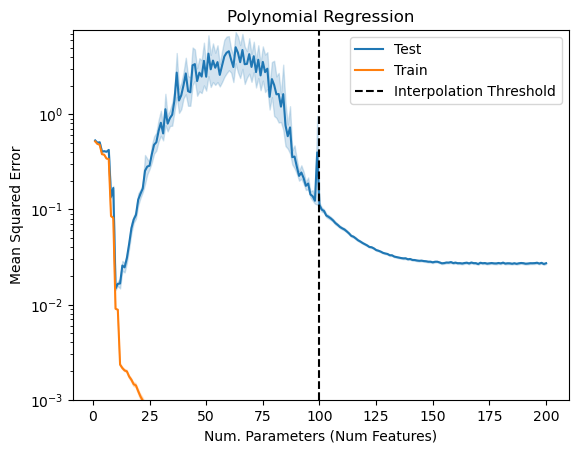

In [10]:
num_data_list = [100]
#num_features_list = [1,5,10,14,15,16,20,50, 60, 70,100,200]
#num_features_list = np.linspace(start=13, stop=17, num=10)
num_features_list = np.arange(1, 201, 1, dtype=int)
num_repeat_list = list(range(700))

# Create sklearn linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)


#def compute_y_from_x(X: np.ndarray):
    #return np.add(2.0 * X, np.cos(X * 25))[:, 0] #the function being fit to
    #return np.add(2.0 * X, np.square(np.cos(X*25)))[:, 0] #squared cosine, which seems to dramatically change the character of the behaivour at the interpolation threshold
#    return np.add(2.0 * X, 0.5 * np.power(np.cos(X*25) , 10))[:, 0] #raising cosine to the 10th power to give very spikey function
def compute_y_from_x(X: np.ndarray):
    return compute_y_from_x_cos_simple(X)

low, high = -1.0, 1.0
for num_data in num_data_list:
    mse_list = []
    #results_num_data_dir = os.path.join(results_dir, f"num_data={num_data}")
    #os.makedirs(results_num_data_dir, exist_ok=True)

    # Generate test data.
    X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
    y_test = compute_y_from_x(X_test)

    # Plot the data.
    '''
    plt.close()
    sns.lineplot(x=X_test[:, 0], y=y_test, label="True Function")
    # sns.scatterplot(x=X_train[:, 0], y=y_train, s=30, color='k', label='Data')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.close()
    '''

    for num_features in tqdm(num_features_list):
        feature_degrees = 1 + np.arange(num_features).astype(int)
        #print(f"feature degrees = ", feature_degrees)
        #print(
        #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
        #)
        for repeat_idx in num_repeat_list:
            # Sample training data.
            X_train = np.random.uniform(low=low, high=high, size=(num_data, 1))
            y_train = compute_y_from_x(X_train)

            # Fit a polynomial regression model.
            X_train_poly = scipy.special.eval_legendre(feature_degrees, X_train)
            X_test_poly = scipy.special.eval_legendre(feature_degrees, X_test)
            beta_hat = np.linalg.pinv(X_train_poly) @ y_train
            y_train_pred = X_train_poly @ beta_hat
            y_test_pred = X_test_poly @ beta_hat
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            mse_list.append(
                {
                    "Num. Data": num_data,
                    "Num. Parameters (Num Features)": num_features,
                    "repeat_idx": repeat_idx,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                }
            )
            #print(
            #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
            #)

    mse_df = pd.DataFrame(mse_list)
    #mse_df[(np.abs(stats.zscore(mse_df)) < 3).all(axis=1)]
    mse_df = mse_df[(np.abs(stats.zscore(mse_df['Test MSE'])) < 2).to_frame().all(axis=1)] #has more agressive and effective outlier clearing
    plt.close()
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Test MSE",
        label="Test",
    )
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Train MSE",
        label="Train",
    )
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=1e-3)
    plt.yscale("log")
    #plt.xscale("log")
    plt.title("Polynomial Regression")
    plt.axvline(
        x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
    )
    plt.legend()
    plt.show()